# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. GBDT (xgboost/lightgbm) </h1>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack,csr_matrix, coo_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
import lightgbm as lgbm

## 1.1 Loading Data

In [3]:
import pandas
data = pandas.read_csv('preprocessed_data.csv', nrows=70000)

## Computing Sentiment Scores:

In [4]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

sentiment_pos=[]
sentiment_neg=[]
sentiment_neu=[]
sentiment_com=[]

for i in data['essay']:
    ss = sid.polarity_scores(i)
    sentiment_pos.append(ss['pos'])
    sentiment_neg.append(ss['neg'])
    sentiment_neu.append(ss['neu'])
    sentiment_com.append(ss['compound'])
    
data['essay_pos_score'] = sentiment_pos
data['essay_neg_score'] = sentiment_neg
data['essay_neu_score'] = sentiment_neu
data['essay_com_score'] = sentiment_com
data.head(1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,essay_pos_score,essay_neg_score,essay_neu_score,essay_com_score
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.205,0.013,0.783,0.9867


In [5]:
sentiment_pos = coo_matrix(sentiment_pos)
print(sentiment_pos.shape)

(1, 70000)


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [6]:
Y = data['project_is_approved'].values
X = data
# X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,essay_pos_score,essay_neg_score,essay_neu_score,essay_com_score
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.205,0.013,0.783,0.9867


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 0)

In [8]:
print(len(X_train))
print(len(X_test))

49000
21000


In [9]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'essay_pos_score', 'essay_neg_score', 'essay_neu_score',
       'essay_com_score'],
      dtype='object')

<h2>1.3 Make Data Model Ready: encoding eassay</h2>

In [10]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [11]:
X_train_essay = X_train['essay']
X_test_essay = X_test['essay']

### Using TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(min_df=10, ngram_range=(1,3))
vectorizer1.fit(X_train_essay)
train_essay_tfidf = vectorizer1.transform(X_train_essay)
test_essay_tfidf = vectorizer1.transform(X_test_essay)
print(train_essay_tfidf.shape)
print(test_essay_tfidf.shape)
print(Y_train.shape, Y_test.shape)

(49000, 150550)
(21000, 150550)
(49000,) (21000,)


### Using TF-IDF W2V

In [13]:
import pickle
store = None

def pickleLoad():
    return pickle.load(open("glove_vectors","rb" ) )

store = pickleLoad()
glove_words =  set(store.keys())

In [14]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train_essay)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [15]:
from tqdm import tqdm
def tfidf_w2v(words):
    tfidf_w2v_vectors = []
    for sentence in tqdm(words): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = store[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return tfidf_w2v_vectors

In [16]:
train_essay_tfidf_w2v = tfidf_w2v(X_train_essay)
test_essay_tfidf_w2v = tfidf_w2v(X_test_essay)
train_essay_tfidf_w2v = coo_matrix(train_essay_tfidf_w2v)
test_essay_tfidf_w2v = coo_matrix(test_essay_tfidf_w2v)

  0%|          | 105/21000 [00:00<00:39, 524.62it/s]

49000
300


100%|██████████| 21000/21000 [00:43<00:00, 479.61it/s]


21000
300


<h2>1.4 Make Data Model Ready: encoding numerical features</h2>

In [17]:
previous_project_scalar = StandardScaler()
previous_project_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {previous_project_scalar.mean_[0]}, Standard deviation : {np.sqrt(previous_project_scalar.var_[0])}")

train_prPos_norm = coo_matrix(previous_project_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)))
test_prPos_norm = coo_matrix(previous_project_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)))

print("After vectorizations")
print(train_prPos_norm.shape, Y_train.shape)
print(test_prPos_norm.shape, Y_test.shape)

Mean : 9.737877551020409, Standard deviation : 25.390665687741212
After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [18]:
from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

train_scaler_price = coo_matrix(price_scalar.transform(X_train['price'].values.reshape(-1, 1)))
test_scaler_price = coo_matrix(price_scalar.transform(X_test['price'].values.reshape(-1, 1)))

print("After vectorizations")
print(train_scaler_price.shape, Y_train.shape)
print(test_scaler_price.shape, Y_test.shape)

Mean : 309.2641893877551, Standard deviation : 369.4015744889598
After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


<h2>1.5 Make Data Model Ready: encoding categorical features using response coding</h2>

In [19]:
def trainResponseCoding(X, cat):
    X.loc[X[cat].isnull(), cat] = 'nan'
    data0 = X[X['project_is_approved'] == 0].groupby(cat).size()
    data1 = X[X['project_is_approved'] == 1].groupby(cat).size()
    return data0, data1

def get_prob(d0, d1, X):
    pos_prob_category = {}
    neg_prob_category = {}
    for i in d0.index:
        pos_prob_category[i] = (d0[i])/(d0[i] + d1[i])
        neg_prob_category[i] = (d1[i])/(d0[i] + d1[i])
    print(d0, d1)
    return pos_prob_category, neg_prob_category

### Teacher Prefix

In [20]:
categories = ['school_state','teacher_prefix','clean_categories','clean_subcategories','project_grade_category']
data_dict = {'X_train':{}, 'X_test': {}}
d0, d1 = trainResponseCoding(X_train, 'teacher_prefix')
tp_pos_prob, tp_neg_prob = get_prob(d0, d1, X_train)

teacher_prefix
dr            1
mr          739
mrs        3809
ms         2816
teacher     208
dtype: int64 teacher_prefix
dr             3
mr          3951
mrs        22124
ms         14539
teacher      810
dtype: int64


In [21]:
teacher_prefix_0_train = []
teacher_prefix_1_train = []
teacher_prefix_0_test = []
teacher_prefix_1_test = []

for i in X_train['teacher_prefix']:
    teacher_prefix_0_train.append(tp_neg_prob[i])
    teacher_prefix_1_train.append(tp_pos_prob[i])
    
X_train['teacher_prefix_0'] = teacher_prefix_0_train
X_train['teacher_prefix_1'] = teacher_prefix_1_train

for i in X_test['teacher_prefix']:
    teacher_prefix_0_test.append(tp_neg_prob[i])
    teacher_prefix_1_test.append(tp_pos_prob[i])
    
X_test['teacher_prefix_0'] = teacher_prefix_0_test
X_test['teacher_prefix_1'] = teacher_prefix_1_test

In [22]:
normalizer = Normalizer()

normalizer.fit(X_train["teacher_prefix_1"].values.reshape(-1,1))

teacher_prefix_1_train = coo_matrix(normalizer.transform(X_train["teacher_prefix_1"].values.reshape(-1,1)))
teacher_prefix_1_test = coo_matrix(normalizer.transform(X_test["teacher_prefix_1"].values.reshape(-1,1)))

print("After vectorizations")
print(teacher_prefix_1_train.shape, Y_train.shape)
print(teacher_prefix_1_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [23]:
normalizer = Normalizer()

normalizer.fit(X_train["teacher_prefix_0"].values.reshape(-1,1))

teacher_prefix_0_train = coo_matrix(normalizer.transform(X_train["teacher_prefix_0"].values.reshape(-1,1)))
teacher_prefix_0_test = coo_matrix(normalizer.transform(X_test["teacher_prefix_0"].values.reshape(-1,1)))

print("After vectorizations")
print(teacher_prefix_0_train.shape, Y_train.shape)
print(teacher_prefix_0_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


### School State

In [24]:
d0, d1 = trainResponseCoding(X_train, 'school_state')
ss_pos_prob, ss_neg_prob = get_prob(d0, d1, X_train)

school_state
ak      22
al     117
ar      89
az     169
ca    1032
co      82
ct      92
dc      46
de      16
fl     495
ga     293
hi      29
ia      37
id      51
il     290
in     166
ks      43
ky      79
la     196
ma     155
md     113
me      24
mi     195
mn      66
mo     153
ms      99
mt      15
nc     362
nd       7
ne      22
nh      19
nj     140
nm      30
nv      94
ny     424
oh     131
ok     170
or     111
pa     213
ri      16
sc     230
sd      23
tn     110
tx     672
ut     159
va     153
vt       5
wa     137
wi     136
wv      43
wy       2
dtype: int64 school_state
ak     131
al     639
ar     421
az     802
ca    6035
co     388
ct     607
dc     181
de     148
fl    2452
ga    1509
hi     176
ia     280
id     256
il    1545
in     986
ks     221
ky     523
la     995
ma     887
md     565
me     188
mi    1136
mn     425
mo    1000
ms     522
mt      89
nc    1945
nd      66
ne     120
nh     139
nj     708
nm     172
nv     513
ny    2679
oh     927
ok  

In [25]:
school_state_0_train = []
school_state_1_train = []
school_state_0_test = []
school_state_1_test = []

for i in X_train['school_state']:
    school_state_0_train.append(ss_neg_prob[i])
    school_state_1_train.append(ss_pos_prob[i])
    
X_train['school_state_0'] = school_state_0_train
X_train['school_state_1'] = school_state_1_train

for i in X_test['school_state']:
    school_state_0_test.append(ss_neg_prob[i])
    school_state_1_test.append(ss_pos_prob[i])
    
X_test['school_state_0'] = school_state_0_test
X_test['school_state_1'] = school_state_1_test
X_train['school_state_0']

59982    0.841962
13048    0.797357
13206    0.870142
25113    0.870142
15311    0.865580
           ...   
21243    0.841962
45891    0.876181
42613    0.827362
43567    0.832033
68268    0.868383
Name: school_state_0, Length: 49000, dtype: float64

In [26]:
normalizer = Normalizer()

normalizer.fit(X_train["school_state_0"].values.reshape(-1,1))

school_state_0_train = coo_matrix(normalizer.transform(X_train["school_state_0"].values.reshape(-1,1)))
school_state_0_test = coo_matrix(normalizer.transform(X_test["school_state_0"].values.reshape(-1,1)))

print("After vectorizations")
print(school_state_0_train.shape, Y_train.shape)
print(school_state_0_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [27]:
normalizer = Normalizer()

normalizer.fit(X_train["school_state_1"].values.reshape(-1,1))

school_state_1_train = coo_matrix(normalizer.transform(X_train["school_state_1"].values.reshape(-1,1)))
school_state_1_test = coo_matrix(normalizer.transform(X_test["school_state_1"].values.reshape(-1,1)))

print("After vectorizations")
print(school_state_1_train.shape, Y_train.shape)
print(school_state_1_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


### project grade category

In [28]:
X_train['project_grade_category']

59982       grades_3_5
13048    grades_prek_2
13206    grades_prek_2
25113    grades_prek_2
15311    grades_prek_2
             ...      
21243       grades_3_5
45891    grades_prek_2
42613       grades_6_8
43567       grades_3_5
68268      grades_9_12
Name: project_grade_category, Length: 49000, dtype: object

In [29]:
d0, d1 = trainResponseCoding(X_train, 'project_grade_category')
pg_pos_prob, pg_neg_prob = get_prob(d0, d1, X_train)

project_grade_category
grades_3_5       2492
grades_6_8       1219
grades_9_12       761
grades_prek_2    3101
dtype: int64 project_grade_category
grades_3_5       14320
grades_6_8        6199
grades_9_12       4044
grades_prek_2    16864
dtype: int64


In [30]:
project_grade_0_train = []
project_grade_1_train = []
project_grade_0_test = []
project_grade_1_test = []

for i in X_train['project_grade_category']:
    project_grade_0_train.append(pg_neg_prob[i])
    project_grade_1_train.append(pg_pos_prob[i])
    
X_train['project_grade_0'] = project_grade_0_train
X_train['project_grade_1'] = project_grade_1_train

for i in X_test['project_grade_category']:
    project_grade_0_test.append(pg_neg_prob[i])
    project_grade_1_test.append(pg_pos_prob[i])
    
X_test['project_grade_0'] = project_grade_0_test
X_test['project_grade_1'] = project_grade_1_test
X_train['project_grade_0']

59982    0.851773
13048    0.844678
13206    0.844678
25113    0.844678
15311    0.844678
           ...   
21243    0.851773
45891    0.844678
42613    0.835670
43567    0.851773
68268    0.841623
Name: project_grade_0, Length: 49000, dtype: float64

In [31]:
normalizer = Normalizer()

normalizer.fit(X_train["project_grade_0"].values.reshape(-1,1))

project_grade_0_train = coo_matrix(normalizer.transform(X_train["project_grade_0"].values.reshape(-1,1)))
project_grade_0_test = coo_matrix(normalizer.transform(X_test["project_grade_0"].values.reshape(-1,1)))

print("After vectorizations")
print(project_grade_0_train.shape, Y_train.shape)
print(project_grade_0_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [32]:
normalizer = Normalizer()

normalizer.fit(X_train["project_grade_1"].values.reshape(-1,1))

project_grade_1_train = coo_matrix(normalizer.transform(X_train["project_grade_1"].values.reshape(-1,1)))
project_grade_1_test = coo_matrix(normalizer.transform(X_test["project_grade_1"].values.reshape(-1,1)))

print("After vectorizations")
print(project_grade_1_train.shape, Y_train.shape)
print(project_grade_1_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


### clean categories

In [33]:
X_train_pos = X_train.loc[Y_train == 1]

clean_cat_pos = {}

for i in X_train_pos['clean_categories']:
    for j in i.split():
        if j not in clean_cat_pos:
            clean_cat_pos[j] = 1
        else:
            clean_cat_pos[j] += 1
clean_cat_pos

{'appliedlearning': 4297,
 'care_hunger': 239,
 'health_sports': 6792,
 'history_civics': 2182,
 'literacy_language': 20096,
 'math_science': 15065,
 'music_arts': 3640,
 'specialneeds': 4876,
 'warmth': 239}

In [34]:
X_train_neg = X_train.loc[Y_train == 0]

clean_cat_neg = {}

for i in X_train_neg['clean_categories']:
    for j in i.split():
        if j not in clean_cat_neg:
            clean_cat_neg[j] = 1
        else:
            clean_cat_neg[j] += 1
clean_cat_neg

{'appliedlearning': 928,
 'care_hunger': 22,
 'health_sports': 1170,
 'history_civics': 380,
 'literacy_language': 3246,
 'math_science': 2904,
 'music_arts': 694,
 'specialneeds': 1012,
 'warmth': 22}

In [35]:
clean_cat_total = {}

for a in X_train['clean_categories'] :
    for b in a.split():
        if b not in clean_cat_total :
            clean_cat_total[b] = 1
        else :
            clean_cat_total[b] += 1
clean_cat_total

{'appliedlearning': 5225,
 'care_hunger': 261,
 'health_sports': 7962,
 'history_civics': 2562,
 'literacy_language': 23342,
 'math_science': 17969,
 'music_arts': 4334,
 'specialneeds': 5888,
 'warmth': 261}

In [36]:
cc_pos_prob = {}

for i in clean_cat_total.keys():
    cc_pos_prob[i] = (clean_cat_pos[i])/float(clean_cat_total[i])
    
cc_neg_prob = {}

for i in clean_cat_total.keys():
    cc_neg_prob[i] = (clean_cat_neg[i])/float(clean_cat_total[i])
cc_neg_prob

{'appliedlearning': 0.17760765550239235,
 'care_hunger': 0.0842911877394636,
 'health_sports': 0.146948003014318,
 'history_civics': 0.1483216237314598,
 'literacy_language': 0.139062633878845,
 'math_science': 0.161611664533363,
 'music_arts': 0.1601292108906322,
 'specialneeds': 0.171875,
 'warmth': 0.0842911877394636}

In [37]:
cat_0_train = []
cat_1_train = []

for a in X_train["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_train.append(cc_neg_prob[a])
        cat_1_train.append(cc_pos_prob[a])
    else :
        neg_prob = 1
        pos_prob = 1
        for i in b:
            neg_prob *= cc_neg_prob[i]
            pos_prob *= cc_pos_prob[i]
        
        cat_0_train.append(neg_prob)
        cat_1_train.append(pos_prob)

X_train['cat_0'] = cat_0_train
X_train['cat_1'] = cat_1_train

In [38]:
cat_0_test = []
cat_1_test = []

for a in X_test["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_test.append(cc_neg_prob[a])
        cat_1_test.append(cc_pos_prob[a])
    else :
        neg_prob = 1
        pos_prob = 1
        for i in b:
            neg_prob *= cc_neg_prob[i]
            pos_prob *= cc_pos_prob[i]
        
        cat_0_test.append(neg_prob)
        cat_1_test.append(pos_prob)
        
X_test['cat_0'] = cat_0_test
X_test['cat_1'] = cat_1_test

In [39]:
normalizer = Normalizer()

normalizer.fit(X_train["cat_0"].values.reshape(-1,1))

cat_0_train = coo_matrix(normalizer.transform(X_train["cat_0"].values.reshape(-1,1)))
cat_0_test = coo_matrix(normalizer.transform(X_test["cat_0"].values.reshape(-1,1)))

print("After vectorizations")
print(cat_0_train.shape, Y_train.shape)
print(cat_0_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [40]:
normalizer = Normalizer()

normalizer.fit(X_train["cat_1"].values.reshape(-1,1))

cat_1_train = coo_matrix(normalizer.transform(X_train["cat_1"].values.reshape(-1,1)))
cat_1_test = coo_matrix(normalizer.transform(X_test["cat_1"].values.reshape(-1,1)))

print("After vectorizations")
print(cat_1_train.shape, Y_train.shape)
print(cat_1_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


### clean sub categories

In [41]:
clean_subcat_pos = {}

for i in X_train_pos['clean_subcategories']:
    for j in i.split():
        if j not in clean_subcat_pos:
            clean_subcat_pos[j] = 1
        else:
            clean_subcat_pos[j] += 1
clean_subcat_pos

{'appliedsciences': 3730,
 'care_hunger': 239,
 'charactereducation': 793,
 'civics_government': 314,
 'college_careerprep': 895,
 'communityservice': 173,
 'earlydevelopment': 1517,
 'economics': 92,
 'environmentalscience': 2004,
 'esl': 1581,
 'extracurricular': 259,
 'financialliteracy': 83,
 'foreignlanguages': 338,
 'gym_fitness': 2191,
 'health_lifescience': 1593,
 'health_wellness': 5207,
 'history_geography': 1226,
 'literacy': 13032,
 'literature_writing': 8515,
 'mathematics': 10348,
 'music': 1244,
 'nutritioneducation': 702,
 'other': 874,
 'parentinvolvement': 137,
 'performingarts': 720,
 'socialsciences': 765,
 'specialneeds': 4876,
 'teamsports': 758,
 'visualarts': 2096,
 'warmth': 239}

In [42]:
clean_subcat_neg = {}

for i in X_train_neg['clean_subcategories']:
    for j in i.split():
        if j not in clean_subcat_neg:
            clean_subcat_neg[j] = 1
        else:
            clean_subcat_neg[j] += 1
clean_subcat_neg

{'appliedsciences': 811,
 'care_hunger': 22,
 'charactereducation': 190,
 'civics_government': 56,
 'college_careerprep': 180,
 'communityservice': 49,
 'earlydevelopment': 353,
 'economics': 18,
 'environmentalscience': 431,
 'esl': 286,
 'extracurricular': 51,
 'financialliteracy': 20,
 'foreignlanguages': 82,
 'gym_fitness': 388,
 'health_lifescience': 336,
 'health_wellness': 803,
 'history_geography': 202,
 'literacy': 2034,
 'literature_writing': 1452,
 'mathematics': 1920,
 'music': 180,
 'nutritioneducation': 152,
 'other': 170,
 'parentinvolvement': 33,
 'performingarts': 116,
 'socialsciences': 139,
 'specialneeds': 1012,
 'teamsports': 200,
 'visualarts': 463,
 'warmth': 22}

In [43]:
clean_subcat_total = {}

for a in X_train['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcat_total :
            clean_subcat_total[b] = 1
        else :
            clean_subcat_total[b] += 1
clean_subcat_total

{'appliedsciences': 4541,
 'care_hunger': 261,
 'charactereducation': 983,
 'civics_government': 370,
 'college_careerprep': 1075,
 'communityservice': 222,
 'earlydevelopment': 1870,
 'economics': 110,
 'environmentalscience': 2435,
 'esl': 1867,
 'extracurricular': 310,
 'financialliteracy': 103,
 'foreignlanguages': 420,
 'gym_fitness': 2579,
 'health_lifescience': 1929,
 'health_wellness': 6010,
 'history_geography': 1428,
 'literacy': 15066,
 'literature_writing': 9967,
 'mathematics': 12268,
 'music': 1424,
 'nutritioneducation': 854,
 'other': 1044,
 'parentinvolvement': 170,
 'performingarts': 836,
 'socialsciences': 904,
 'specialneeds': 5888,
 'teamsports': 958,
 'visualarts': 2559,
 'warmth': 261}

In [44]:
sc_pos_prob = {}

for i in clean_subcat_total.keys():
    sc_pos_prob[i] = (clean_subcat_pos[i])/float(clean_subcat_total[i])
    
sc_neg_prob = {}

for i in clean_subcat_total.keys():
    sc_neg_prob[i] = (clean_subcat_neg[i])/float(clean_subcat_total[i])
sc_neg_prob

{'appliedsciences': 0.1785950231226602,
 'care_hunger': 0.0842911877394636,
 'charactereducation': 0.19328585961342828,
 'civics_government': 0.15135135135135136,
 'college_careerprep': 0.16744186046511628,
 'communityservice': 0.22072072072072071,
 'earlydevelopment': 0.18877005347593584,
 'economics': 0.16363636363636364,
 'environmentalscience': 0.17700205338809036,
 'esl': 0.1531869309051955,
 'extracurricular': 0.16451612903225807,
 'financialliteracy': 0.1941747572815534,
 'foreignlanguages': 0.19523809523809524,
 'gym_fitness': 0.1504459092671578,
 'health_lifescience': 0.17418351477449456,
 'health_wellness': 0.13361064891846922,
 'history_geography': 0.14145658263305322,
 'literacy': 0.13500597371565112,
 'literature_writing': 0.145680746463329,
 'mathematics': 0.156504727746984,
 'music': 0.12640449438202248,
 'nutritioneducation': 0.17798594847775176,
 'other': 0.16283524904214558,
 'parentinvolvement': 0.19411764705882353,
 'performingarts': 0.13875598086124402,
 'socialsci

In [45]:
subcat_0_train = []
subcat_1_train = []

for a in X_train["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_0_train.append(sc_neg_prob[a])
        subcat_1_train.append(sc_pos_prob[a])
    else :
        neg_prob = 1
        pos_prob = 1
        for i in b:
            neg_prob *= sc_neg_prob[i]
            pos_prob *= sc_pos_prob[i]
        
        subcat_0_train.append(neg_prob)
        subcat_1_train.append(pos_prob)
        
X_train['subcat_0'] = subcat_0_train
X_train['subcat_1'] = subcat_1_train

In [46]:
subcat_0_test = []
subcat_1_test = []

for a in X_test["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_0_test.append(sc_neg_prob[a])
        subcat_1_test.append(sc_pos_prob[a])
    else :
        neg_prob = 1
        pos_prob = 1
        for i in b:
            neg_prob *= sc_neg_prob[i]
            pos_prob *= sc_pos_prob[i]
        
        subcat_0_test.append(neg_prob)
        subcat_1_test.append(pos_prob)
        
X_test['subcat_0'] = subcat_0_test
X_test['subcat_1'] = subcat_1_test

In [47]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

normalizer.fit(X_train["subcat_0"].values.reshape(-1,1))

subcat_0_train = coo_matrix(normalizer.transform(X_train["subcat_0"].values.reshape(-1,1)))
subcat_0_test = coo_matrix(normalizer.transform(X_test["subcat_0"].values.reshape(-1,1)))

print("After vectorizations")
print(subcat_0_train.shape, Y_train.shape)
print(subcat_0_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [48]:
normalizer = Normalizer()

normalizer.fit(X_train["subcat_1"].values.reshape(-1,1))

subcat_1_train = coo_matrix(normalizer.transform(X_train["subcat_1"].values.reshape(-1,1)))
subcat_1_test = coo_matrix(normalizer.transform(X_test["subcat_1"].values.reshape(-1,1)))

print("After vectorizations")
print(subcat_1_train.shape, Y_train.shape)
print(subcat_1_test.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


<h2>1.6 Essay Sentiment Scores </h2>

In [49]:
from sklearn.preprocessing import StandardScaler

pos_scalar = StandardScaler()
pos_scalar.fit(X_train['essay_pos_score'].values.reshape(-1,1))

train_scaler_pos = coo_matrix(pos_scalar.transform(X_train['essay_pos_score'].values.reshape(-1, 1)))
test_scaler_pos = coo_matrix(pos_scalar.transform(X_test['essay_pos_score'].values.reshape(-1, 1)))

print("After vectorizations")
print(train_scaler_pos.shape, Y_train.shape)
print(test_scaler_pos.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [50]:
from sklearn.preprocessing import StandardScaler

neg_scalar = StandardScaler()
neg_scalar.fit(X_train['essay_neg_score'].values.reshape(-1,1))

train_scaler_neg = coo_matrix(neg_scalar.transform(X_train['essay_neg_score'].values.reshape(-1, 1)))
test_scaler_neg = coo_matrix(neg_scalar.transform(X_test['essay_neg_score'].values.reshape(-1, 1)))

print("After vectorizations")
print(train_scaler_neg.shape, Y_train.shape)
print(test_scaler_neg.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [51]:
from sklearn.preprocessing import StandardScaler

neu_scalar = StandardScaler()
neu_scalar.fit(X_train['essay_neu_score'].values.reshape(-1,1))

train_scaler_neu = coo_matrix(neu_scalar.transform(X_train['essay_neu_score'].values.reshape(-1, 1)))
test_scaler_neu = coo_matrix(neu_scalar.transform(X_test['essay_neu_score'].values.reshape(-1, 1)))

print("After vectorizations")
print(train_scaler_neu.shape, Y_train.shape)
print(test_scaler_neu.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


In [52]:
from sklearn.preprocessing import StandardScaler

com_scalar = StandardScaler()
com_scalar.fit(X_train['essay_com_score'].values.reshape(-1,1))

train_scaler_com = coo_matrix(com_scalar.transform(X_train['essay_com_score'].values.reshape(-1, 1)))
test_scaler_com = coo_matrix(com_scalar.transform(X_test['essay_com_score'].values.reshape(-1, 1)))

print("After vectorizations")
print(train_scaler_com.shape, Y_train.shape)
print(test_scaler_com.shape, Y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)


<h1>2. Appling Models on different kind of featurization as mentioned in the instructions</h1>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [53]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

## Stacking all vectors

### Set 1

In [54]:
X_set1_train = []
X_set1_train = hstack(( cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, project_grade_0_train, 
                       project_grade_1_train, school_state_0_train, school_state_1_train, teacher_prefix_0_train, 
                       teacher_prefix_1_train, train_scaler_price, train_prPos_norm, train_essay_tfidf, 
                       train_scaler_pos, train_scaler_neg, train_scaler_neu, train_scaler_com 
                      ))
print(X_set1_train.shape, Y_train.shape)

X_set1_test = []
X_set1_test = hstack(( cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, project_grade_0_test, 
                       project_grade_1_test, school_state_0_test, school_state_1_test, teacher_prefix_0_test, 
                       teacher_prefix_1_test, test_scaler_price, test_prPos_norm, test_essay_tfidf, 
                       test_scaler_pos, test_scaler_neg, test_scaler_neu, test_scaler_com 
                      ))
print(X_set1_test.shape, Y_test.shape)

(49000, 150566) (49000,)
(21000, 150566) (21000,)


### Set 2

In [79]:
X_set2_train = []
X_set2_train = hstack(( cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, project_grade_0_train, 
                       project_grade_1_train, school_state_0_train, school_state_1_train, teacher_prefix_0_train, 
                       teacher_prefix_1_train, train_scaler_price, train_prPos_norm, train_essay_tfidf_w2v
                      ))
print(X_set2_train.shape, Y_train.shape)

X_set2_test = []
X_set2_test = hstack(( cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, project_grade_0_test, 
                       project_grade_1_test, school_state_0_test, school_state_1_test, teacher_prefix_0_test, 
                       teacher_prefix_1_test, test_scaler_price, test_prPos_norm, test_essay_tfidf_w2v
                      ))
print(X_set2_test.shape, Y_test.shape)

(49000, 312) (49000,)
(21000, 312) (21000,)


## Applying Light GBM on Set 1

In [56]:
def pred_prob(clf, data): 
    y_pred = []
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

In [57]:
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators' : [10, 50, 100, 150, 300, 400, 500, 700, 800, 1000],
    'max_depth' : [2, 3, 4, 5]
}

estimator = lgbm.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')

model = GridSearchCV(estimator, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
lgbmodel = model.fit(X_set1_train,Y_train)

print(lgbmodel.best_score_)
print(lgbmodel.best_estimator_)
print(lgbmodel.best_params_)

0.7227332761392923
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=2, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
{'max_depth': 2, 'n_estimators': 500}


In [58]:
print('Best score: ',lgbmodel.best_score_)
print('k value with best score: ',lgbmodel.best_params_)
print('='*75)
print('Train AUC scores')
print(lgbmodel.cv_results_['mean_train_score'])
print('CV AUC scores')
print(model.cv_results_['mean_test_score'])

Best score:  0.7227332761392923
k value with best score:  {'max_depth': 2, 'n_estimators': 500}
Train AUC scores
[0.65683266 0.71196952 0.741022   0.76005075 0.79797237 0.81520867
 0.83048925 0.85501864 0.8653034  0.88310356 0.6785217  0.74562877
 0.78253806 0.80644848 0.85163754 0.87187455 0.88883935 0.91561997
 0.92590974 0.94220606 0.7057282  0.78056101 0.82195917 0.847986
 0.89401615 0.91465785 0.93141282 0.95518283 0.96325492 0.97551731
 0.73325812 0.81762279 0.86008499 0.88509731 0.92800521 0.94645634
 0.95999801 0.97677397 0.98244607 0.99005004]
CV AUC scores
[0.64569567 0.6897847  0.70592944 0.71302925 0.72064769 0.72176864
 0.72273328 0.72266778 0.72212919 0.7209802  0.65981149 0.69939986
 0.71393802 0.71843418 0.72221913 0.7222502  0.72059244 0.71923611
 0.71802178 0.71617066 0.67381368 0.70752803 0.71757999 0.72000114
 0.72153793 0.72024526 0.71835955 0.71498519 0.71421371 0.71105858
 0.67826639 0.71109641 0.71922954 0.72030308 0.7200756  0.71826616
 0.71544873 0.71230528 0.

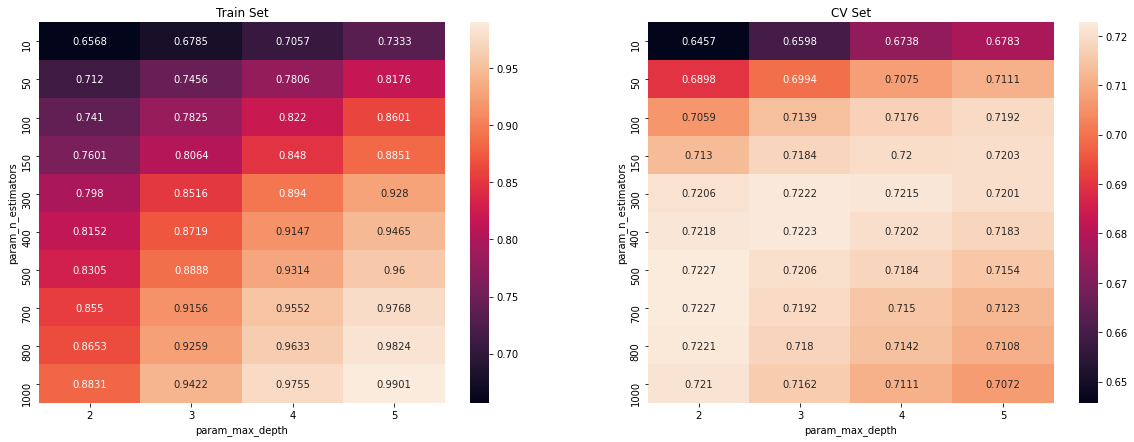

In [59]:
import seaborn as sns
max_scores1 = pd.DataFrame(model.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,7))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

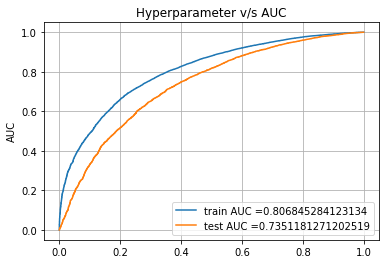

In [75]:
from sklearn.metrics import roc_curve, auc

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 2, n_estimators = 500)
gbdt.fit(X_set1_train,Y_train)
    
y_train_pred = pred_prob(gbdt,X_set1_train)
y_test_pred = pred_prob(gbdt,X_set1_test)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc1 = auc(test_fpr, test_tpr)
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

In [76]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3)) 
    return t


def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [77]:
import numpy as np
print("="*100)
from sklearn.metrics import confusion_matrix
best_t1 = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t1)))

the maximum value of tpr*(1-fpr) 0.5365750366821697 for threshold 0.5
Train confusion matrix
[[ 5725  1848]
 [12023 29404]]


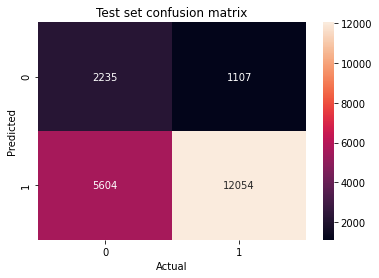

In [78]:
import seaborn as sns
heatmap_train = sns.heatmap(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t1)), annot=True, fmt="d")
plt.title("Test set confusion matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## Applying Light GBM on Set 2:

In [82]:
param_grid = {
    'n_estimators' : [10, 50, 100, 150, 300, 400, 500, 700, 800, 1000],
    'max_depth' : [2, 3, 4, 5]
}

estimator = lgbm.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')

model2 = GridSearchCV(estimator, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
lgbmodel2 = model2.fit(X_set2_train,Y_train)

print(lgbmodel2.best_score_)
print(lgbmodel2.best_estimator_)
print(lgbmodel2.best_params_)

0.7036587834858277
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=2, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
{'max_depth': 2, 'n_estimators': 300}


In [83]:
print('Best score: ',lgbmodel2.best_score_)
print('k value with best score: ',lgbmodel2.best_params_)
print('='*75)
print('Train AUC scores')
print(lgbmodel2.cv_results_['mean_train_score'])
print('CV AUC scores')
print(model2.cv_results_['mean_test_score'])

Best score:  0.7036587834858277
k value with best score:  {'max_depth': 2, 'n_estimators': 300}
Train AUC scores
[0.67278375 0.71536834 0.73674844 0.75058539 0.781467   0.79719345
 0.81102825 0.834769   0.84475207 0.86234201 0.69052642 0.74736574
 0.77960109 0.80478276 0.85832978 0.88422111 0.90491607 0.93589787
 0.94701704 0.96402749 0.71606113 0.78920391 0.8376236  0.87230346
 0.93718711 0.96169603 0.97628475 0.99148326 0.99499194 0.99827112
 0.75262122 0.84625582 0.90690498 0.94350073 0.98786052 0.99585509
 0.99867125 0.99986553 0.9999502  0.99998854]
CV AUC scores
[0.65377319 0.68591784 0.6962636  0.7002652  0.70365878 0.70345054
 0.70284502 0.70260259 0.7020297  0.70101712 0.66469519 0.69417252
 0.70053088 0.70275296 0.70167952 0.70041    0.69937222 0.69671344
 0.69558115 0.69333404 0.67109518 0.69823526 0.70202655 0.70205528
 0.69839723 0.69532015 0.69274054 0.68937958 0.68773764 0.68496762
 0.67762783 0.69888261 0.6993735  0.6971875  0.68978702 0.6871449
 0.68498453 0.68126341 0

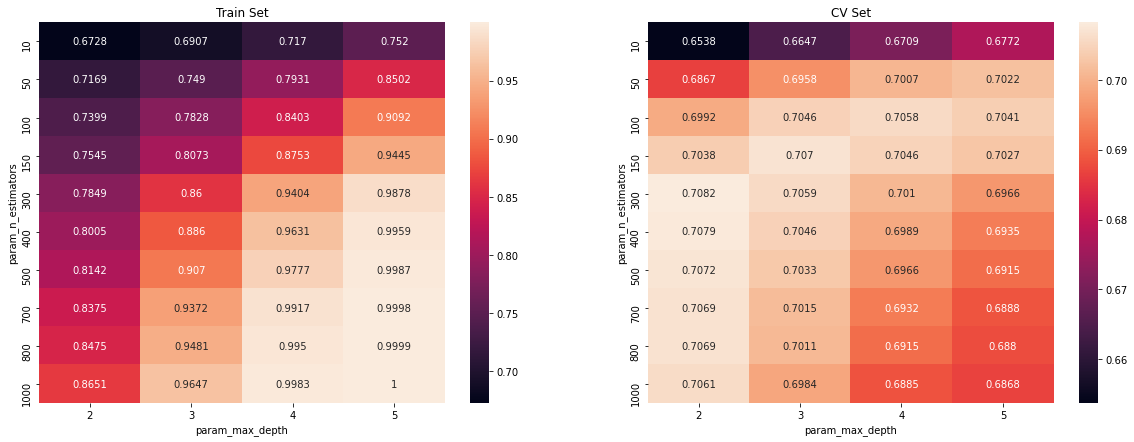

In [84]:
import seaborn as sns
max_scores2 = pd.DataFrame(model.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,7))
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

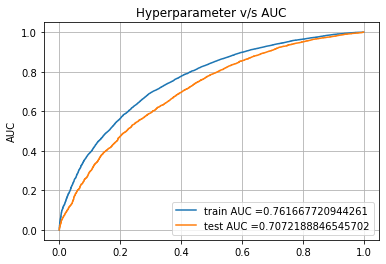

In [85]:
from sklearn.metrics import roc_curve, auc

gbdt2 = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 2, n_estimators = 300)
gbdt2.fit(X_set2_train,Y_train)
    
y_train_pred = pred_prob(gbdt2,X_set2_train)
y_test_pred = pred_prob(gbdt2,X_set2_test)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc2 = auc(test_fpr, test_tpr)
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

In [86]:
import numpy as np
print("="*100)
from sklearn.metrics import confusion_matrix
best_t2 = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t2)))

the maximum value of tpr*(1-fpr) 0.48607459006888193 for threshold 0.497
Train confusion matrix
[[ 5343  2230]
 [12886 28541]]


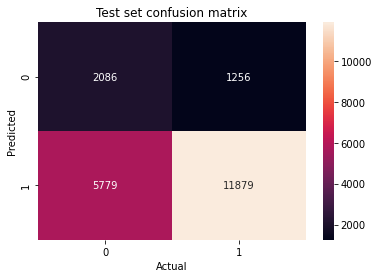

In [87]:
import seaborn as sns
heatmap_train = sns.heatmap(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t2)), annot=True, fmt="d")
plt.title("Test set confusion matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

<h1>3. Summary</h1>

In [88]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Max Depth", "No. Of Base Models", "Test AUC"]

x.add_row(["TFIDF", "LightGBM GBDT", 2, 500, auc1])
x.add_row([" ", " ", " ", " ", " "])
x.add_row(["TFIDF W2V", "LightGBm GBDT", 2, 300, auc2])

print(x)

+------------+---------------+-----------+--------------------+--------------------+
| Vectorizer |     Model     | Max Depth | No. Of Base Models |      Test AUC      |
+------------+---------------+-----------+--------------------+--------------------+
|   TFIDF    | LightGBM GBDT |     2     |        500         | 0.7351181271202519 |
|            |               |           |                    |                    |
| TFIDF W2V  | LightGBm GBDT |     2     |        300         | 0.7072188846545702 |
+------------+---------------+-----------+--------------------+--------------------+
